# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 22

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmenttion as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

### 1.1 Brain image visualization

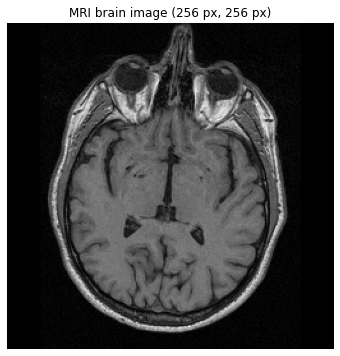

In [2]:
import skimage.io
import skimage.measure
import skimage.filters
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing (5pts)

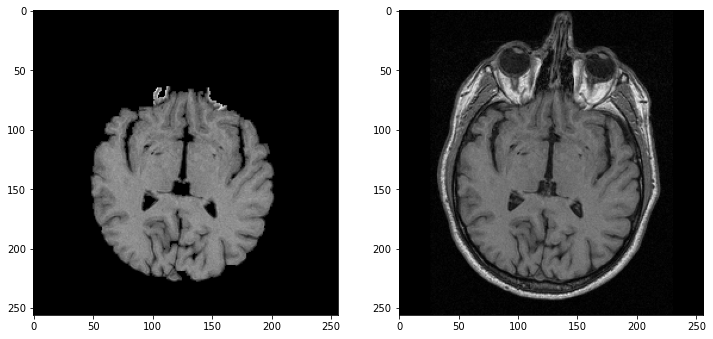

In [3]:
# Add your implementation and discussion
length=brain_im.shape[0] # Length of image
sample=brain_im[130:150,140:160] # Sample of image to mean onto
brain_copy=brain_im.copy()

thresh=np.mean(sample)*0.6
thresh2=np.mean(sample)*1.1
mask=brain_im>thresh


#Try
start=[210,125]
region=[start]
Exploring_map=np.zeros((length,length))
Exploring_map[start[0],start[1]]=2
process=True

while process :
    for pixel in region:
        X,Y = np.mgrid[pixel[0]-1:pixel[0]+2,pixel[1]-1:pixel[1]+2]#Find surrounding pixels
        Xsurr,Ysurr=np.vstack((X.ravel(), Y.ravel())) 
        Surr=np.vstack((Xsurr,Ysurr)).T #Making array with surrounding pixels coordinates
        for exp in Surr :
            if Exploring_map[exp[0],exp[1]] == 0: # If never explored
                if brain_copy[exp[0],exp[1]]>thresh and brain_copy[exp[0],exp[1]]<thresh2 : #If in range for brain
                    Exploring_map[exp[0],exp[1]] = 2
                else:
                    Exploring_map[exp[0],exp[1]] = 1 # If never explored and not in threshold
            elif Exploring_map[exp[0],exp[1]] ==2:# If already inquired, try once more for pixels around
                Exploring_map[exp[0],exp[1]]=3
            elif Exploring_map[exp[0],exp[1]] ==3:# If already inquired, exclude from next pixels to explore
                Exploring_map[exp[0],exp[1]]=4    
                
    region=np.vstack((np.where((Exploring_map==2)|(Exploring_map==3)))).transpose()
    #print(region)
    if region.shape[0]==0:
        process = False
    
mask=Exploring_map<1
brain_copy[mask]=0 #See the whole brain region

# Display Images of the brain
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].imshow(brain_copy, cmap='gray')
ax[1].imshow(brain_im, cmap='gray')
plt.show()


### 1.3 Contour detection (5pts)

In [4]:
# Add your implementation and discussion

### 1.4 Additional method (5pts)

In [5]:
# Add your implementation and discussion

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

### 2.1 Visualization

In [6]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


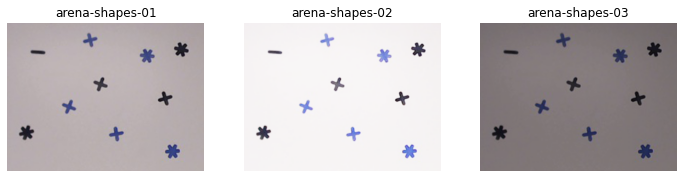

In [7]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()


### 2.2 Number of shapes of each color (5 pts)

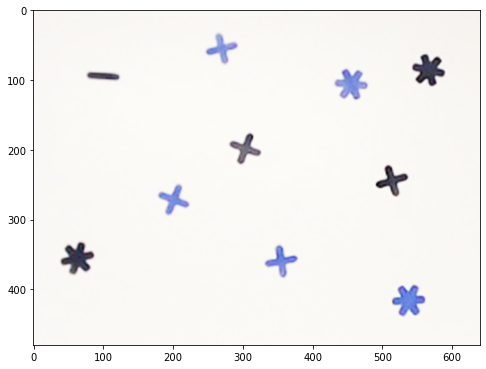

The number of dominant colors in this image is :  3


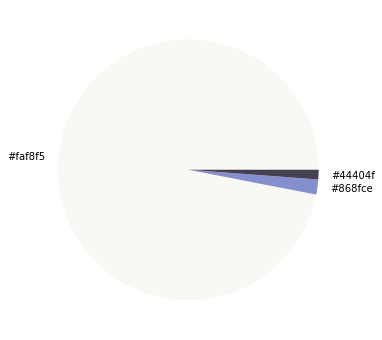

In [8]:
# Add your implementation and discussion
#https://github.com/kb22/Color-Identification-using-Machine-Learning/blob/master/Color%20Identification%20using%20Machine%20Learning.ipynb

import cv2
from collections import Counter
from skimage import measure
from skimage.color import rgb2lab, deltaE_cie76,rgb2gray
from sklearn.cluster import KMeans
import itertools
from PIL import Image
import scipy as sc

def get_image(num):
    image = images[num]
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def normalize(arr):
    """
    Linear normalization
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    """
    arr = arr.astype('float')
    # Do not touch the alpha channel
    for i in range(3):
        minval = arr[...,i].min()
        maxval = arr[...,i].max()
        if minval != maxval:
            arr[...,i] -= minval
            arr[...,i] *= (255.0/(maxval-minval))
    return arr

def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def get_colors(image, number_of_colors, show_chart):
    modified_image = image
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
   
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    #Print the steps to find the number of dominant colors :
   # print(counts)
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    
    return rgb_colors,counts


image = get_image(1) #Choose which image to take

arr=np.array(image) #Normalize it
image = np.array(Image.fromarray(normalize(arr).astype('uint8'),'RGB'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8)) #Plot ot
ax.imshow(image)
plt.show()

not_stable = True
num_colors=10


while not_stable:
    rgb,counts=get_colors(image, num_colors, False)
    it=0

    for a, b in itertools.combinations(rgb, 2):
        it+=1
        if np.linalg.norm(a-b)<100: #If shades of color are too close
            num_colors-=1 
            break
        else: 
            if(it==sc.special.binom(num_colors,2)): #Check if last iteration
                rgb,counts=get_colors(image, num_colors, True)
                not_stable = False        
print('The number of dominant colors in this image is : ', num_colors)



In [9]:
# Find the contours to find the number of elements
gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 190, 255, 0)
contours, hierarchy= cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
number_of_objects_in_image= len(contours)

colpix=np.array(list(counts.copy().items()))
idx=np.argmax(colpix[:,1])
colpix = np.delete(colpix,idx,0)#Remove background from colors for the objects

#Find to which color the elements belong
color_table=np.zeros(number_of_objects_in_image)
for num in range(number_of_objects_in_image):
    center=(np.floor(np.mean(contours[num],axis=0)))
    weight_color=1000
    for num2 in range(num_colors):       
        new_weight=np.linalg.norm(image[int(center[0,1]),int(center[0,0])]-rgb[num2])
        if(new_weight<weight_color):
            weight_color=new_weight
            color_table[num]=num2

            
color_table = np.delete(color_table,idx)
print('Color table:',color_table)
print ("The number of objects in this image: ", str(number_of_objects_in_image-1))
for num in colpix[:,0]:
    print('The number of shape for color',num,'is',list(color_table).count(num))
#To draw the contours :
'''
cv2.drawContours(image,contours,-1,(0,255,255),2)
cv2.namedWindow('Display',cv2.WINDOW_NORMAL)
cv2.imshow('Display',image)
cv2.waitKey()
'''

Color table: [1. 1. 2. 1. 2. 2. 2. 1. 2. 1.]
The number of objects in this image:  10
The number of shape for color 1 is 5
The number of shape for color 2 is 5


"\ncv2.drawContours(image,contours,-1,(0,255,255),2)\ncv2.namedWindow('Display',cv2.WINDOW_NORMAL)\ncv2.imshow('Display',image)\ncv2.waitKey()\n"

### 2.3 Total area (in pixels) of each color (5 pts)

In [10]:
# Add your implementation and discussion
for num in colpix[:,0]: 
    print('The number of pixels for the color',num,'is',colpix[num-1,1])

The number of pixels for the color 1 is 5717
The number of pixels for the color 2 is 3663
